# Software Archaeology and Refactoring

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

# https://matplotlib.org/users/colormaps.html
from matplotlib.colors import ListedColormap

colors = ['#FF0000', '#0000FF', '#FFFF00']

cmap = ListedColormap(colors)

In [2]:
random_seed = 42

In [3]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html

from matplotlib.ticker import FuncFormatter

import numpy as np

def meshGrid(x_data=None, y_data=None):
    h = 1  # step size in the mesh
#     x_min, x_max = 10, 110
#     y_min, y_max = 80, 170
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)

def plot_samples(samples, ax, legend):
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=50, marker='o', edgecolors='k')

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
    ax.add_artist(class_legend)
    
    return ax, scatter

def plot_samples_markers(samples, ax, legend):
  y = samples[2]
  bad = samples[y == 0]
  good = samples[y == 1]
  fair = samples[y == 2]

  labels = ["High Risk", "Low Risk", "Medium Risk"]
  classes = [bad, good, fair]
  markers = ['v', 'd', '^']

  for label, clazz, color, marker in zip(labels, classes, colors, markers):
      ax.scatter(
          clazz[0], 
          clazz[1],
          label=label,
          color=color,
          marker=marker,
          s=100,
          edgecolors='k',
          alpha=0.8)
  if legend:
    ax.legend()
  return ax, None
      

def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   n_samples=None, proba=True, prediction=True, legend=True, 
                   scatter=True,
                   X=None,
                   ax=None
                  ):
    if x_data is not None:
      assert x_data.shape == y_data.shape, "x and y must have the same dimension"
    if x_data  is not None and ground_truth is not None:
      assert x_data.shape == ground_truth.shape, "input and ground truth need the same number of samples"
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      fig, ax = plt.subplots()

    if clf:
        if X is not None:
          Z = clf.predict_proba(X)
        else:
          Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    
    if scatter:
      samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
      if n_samples:
        samples = samples.sample(n_samples, random_state=42)
      plot_samples_markers(samples, ax, legend)
    return ax 


In [4]:
red = high = 0
green = low = 1
yellow = medium = 2

probas = np.array([
                   [1, 0, 0],
                   [0, 1, 0],
                   [0, 0, 1]
])

class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def predict_proba(self, X):
        return np.array([probas[xi] for xi in self.predict(X)])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n


# Step 0: Risk Classficiation - Understand the data and the challenge

In [5]:
import pandas as pd

# df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/insurance-customers-1500.csv', sep=';')
# local
df = pd.read_csv('../data/insurance-customers-1500.csv', sep=';')

In [6]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [7]:
# groups: "High Risk", "Low Risk", "Medium Risk"
  
y = df['group'].values
X = df.drop('group', axis='columns').values

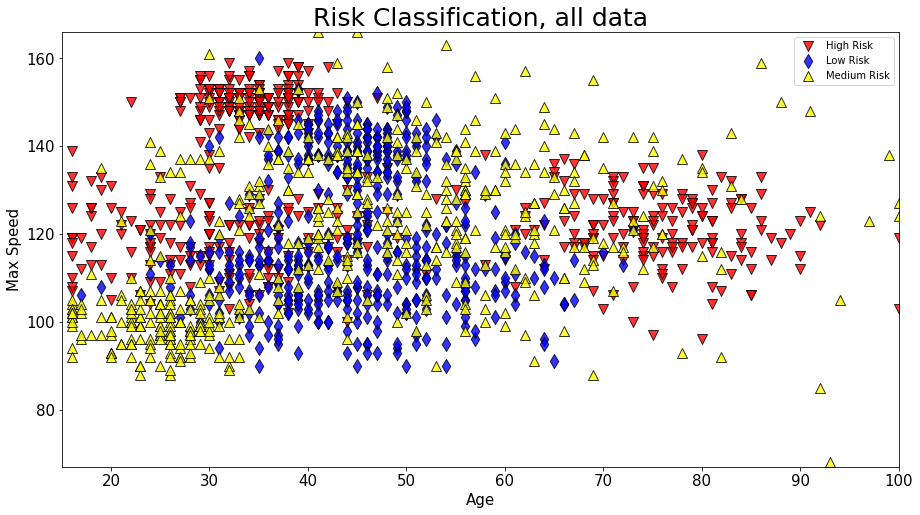

In [8]:
plotPrediction(clf=None, x_data=X[:, 1], y_data=X[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y,
                title="Risk Classification, all data");

## Shared Hands-On: Let us create some classic code serving as legacy data

### Code like this gets messy really quick

In [9]:
def predict_risk(speed, age):
    if speed < 100:
      return low
    if speed > 140:
      return high
    return medium

# Step 1: Some Archaeology - What does the code do? Is it even good?

0.36333333333333334

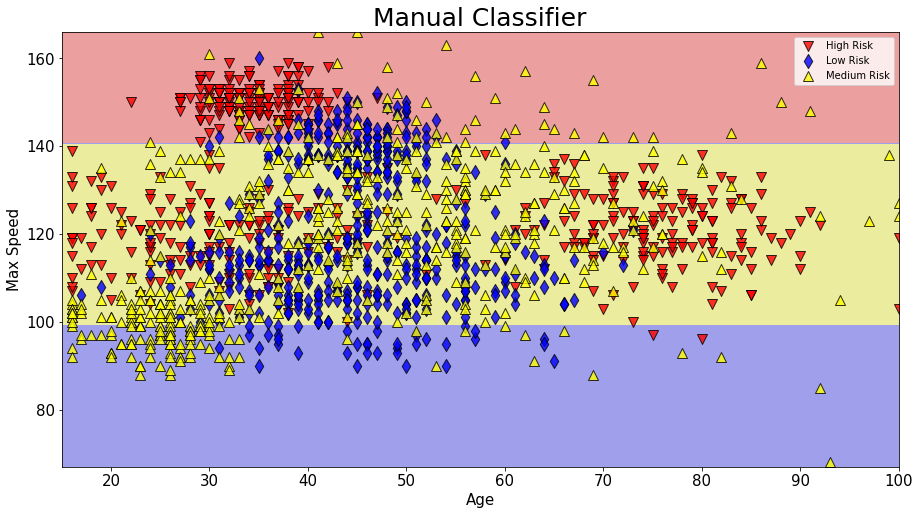

In [10]:
class RuleClassifier(ClassifierBase):
    def predict_single(self, x):
        speed, age = x
        return predict_risk(speed, age)
    
rule_clf = RuleClassifier()
plotPrediction(clf=rule_clf, x_data=X[:, 1], y_data=X[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y,
                title="Manual Classifier");
rule_clf.score(X[:, :2], y)

## and some more scary archaelogy

https://beta.openai.com/playground?model=davinci-codex

```
# Python

# Begin

def predict_risk(speed, age):
    if speed < 100:
      return low
    if speed > 140:
      return high
    return medium

# End    

# What does this function predict_risk do?
```

### and some more

```
# Python

# Begin

def predict_risk(speed, age):
    if age < 30:
        if speed > 110:
            return high
        else:
            return medium
    if age > 70:
        return high
    if speed > 145:
        return high
    # this default vastly simplifies rule set    
    return low
    
# End    

# Simplified version
```

In [11]:
# backup
def predict_risk(speed, age):
    if age < 30:
        if speed > 110:
            return high
        else:
            return medium
    if age > 70:
        return high
    if speed > 145:
        return high
    # this default vastly simplifies rule set    
    return low

# Step 2: Sample over the function

In [12]:
xx,yy = meshGrid(x_data=X[:, 1], y_data=X[:, 0])
mesh_data = np.c_[yy.ravel(), xx.ravel()]
mesh_data.shape

(8600, 2)

In [13]:
pred = rule_clf.predict(mesh_data)
pred.shape

(8600,)

In [14]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
#     class_weight="balanced",
    random_state=random_seed,
    max_leaf_nodes = 20,
    max_depth=10
)
%time surrogate_model.fit(mesh_data, pred)

CPU times: user 1.96 ms, sys: 0 ns, total: 1.96 ms
Wall time: 1.97 ms


DecisionTreeClassifier(max_depth=10, max_leaf_nodes=20, random_state=42)

In [15]:
surrogate_model.tree_.max_depth

4

In [16]:
surrogate_model.score(X[:, :2], y)

0.6233333333333333

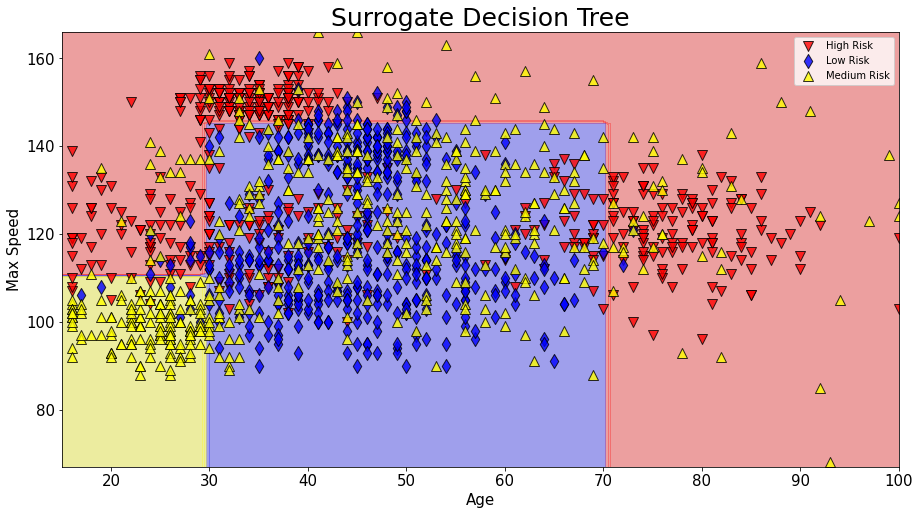

In [17]:
plotPrediction(clf=surrogate_model, x_data=X[:, 1], y_data=X[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y,
                title="Surrogate Decision Tree");

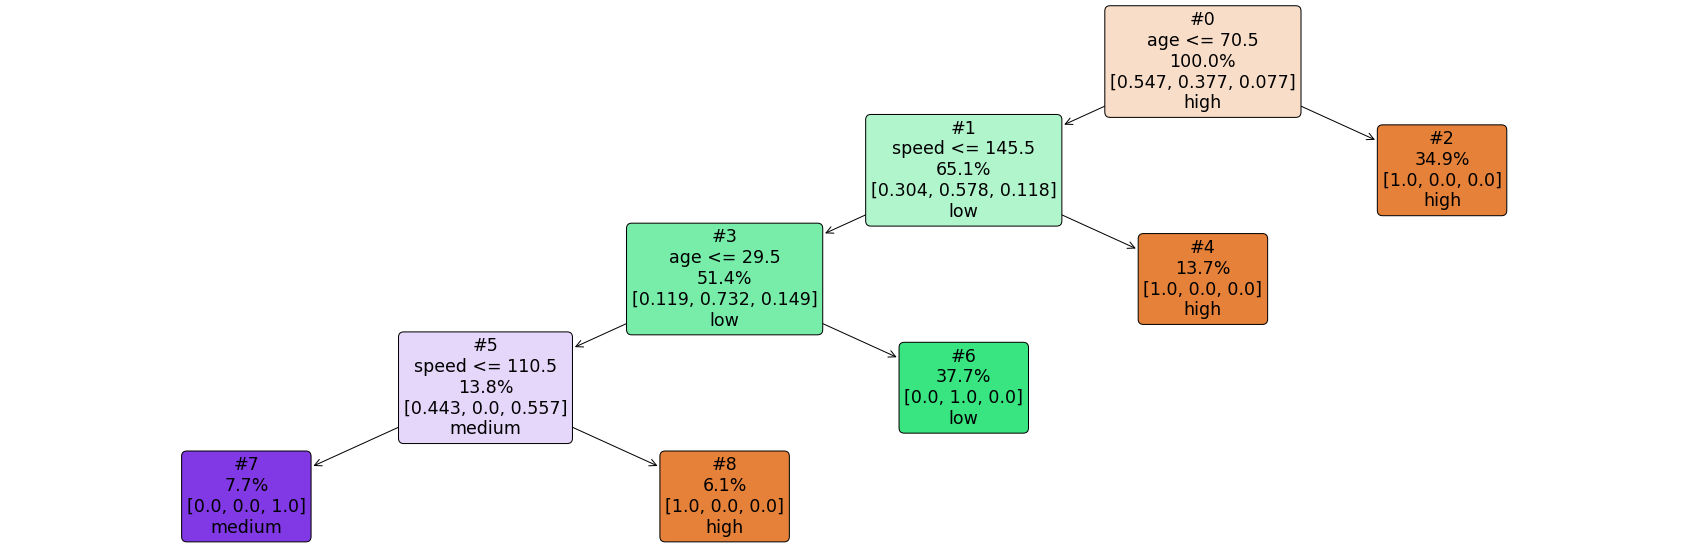

In [18]:
# https://scikit-learn.org/stable/modules/tree.html
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
# https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names=['speed', 'age']
class_names=['high', 'low', 'medium']

plt.figure(figsize=(30, 10))
plot_tree(surrogate_model, 
          feature_names=feature_names,
          class_names=class_names,
          impurity=False,
          label='none',
          rounded=True,
          node_ids=True,
          proportion=True,
          filled=True);

## Which parameter has importance on the decision?

In [19]:
# speed, age
surrogate_model.feature_importances_

array([0.38344573, 0.61655427])

## Visualizing Prediction Path using dtreeviz

https://github.com/parrt/dtreeviz

In [20]:
import sys

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


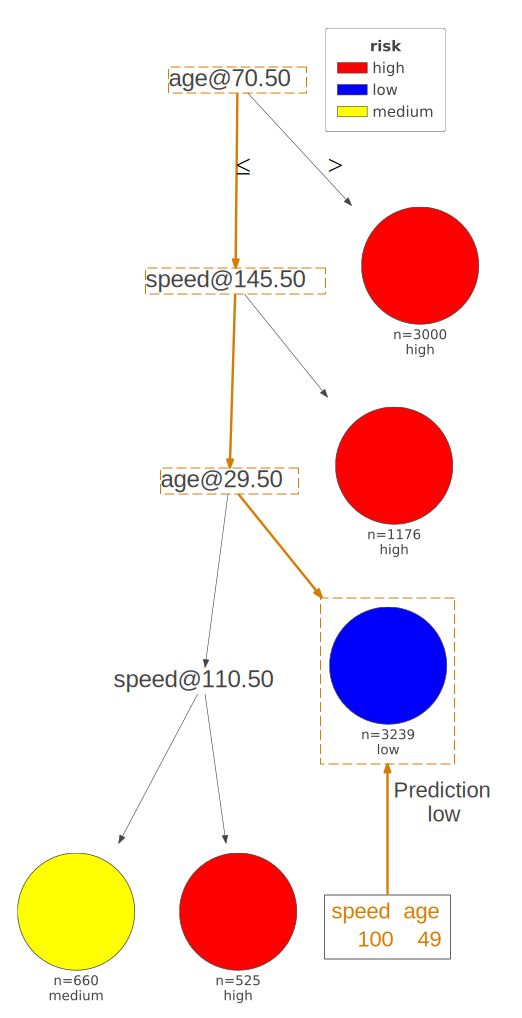

In [21]:
from dtreeviz.trees import dtreeviz

# sample = [100, 35]
# sample = [150, 30]
sample = [100, 49]
# sample = [100, 60]
# sample = [120, 17]

dtreeviz_colors = {'classes': [
                   None,  # 0 classes
                   None,  # 1 classes
                   None,  # 2 classes
                   colors
                   ]}

viz = dtreeviz(surrogate_model,
               mesh_data, pred,
               target_name='risk',
               feature_names=feature_names,
               class_names=class_names,
               X=sample,
               colors=dtreeviz_colors,
               fancy=False,
               scale=2,
#                scale=3
)
viz

# Step 3: Refactoring - can we simplify the code?

## Restricting depth of tree and exit paths

In [22]:
max_depth = 3
exit_paths = 5

In [23]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
#     class_weight="balanced",
    random_state=random_seed,
    max_leaf_nodes = exit_paths,
    max_depth=max_depth
)
%time surrogate_model.fit(mesh_data, pred)

CPU times: user 1.87 ms, sys: 678 µs, total: 2.54 ms
Wall time: 2.35 ms


DecisionTreeClassifier(max_depth=3, max_leaf_nodes=5, random_state=42)

In [24]:
surrogate_model.tree_.max_depth

3

In [25]:
surrogate_model.score(X[:, :2], y)

0.592

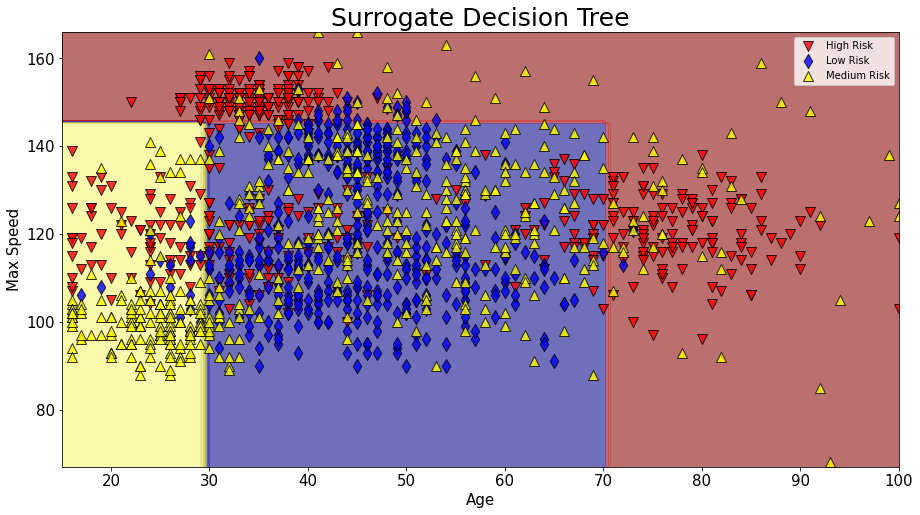

In [26]:
plotPrediction(clf=surrogate_model, x_data=X[:, 1], y_data=X[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y,
                title="Surrogate Decision Tree");

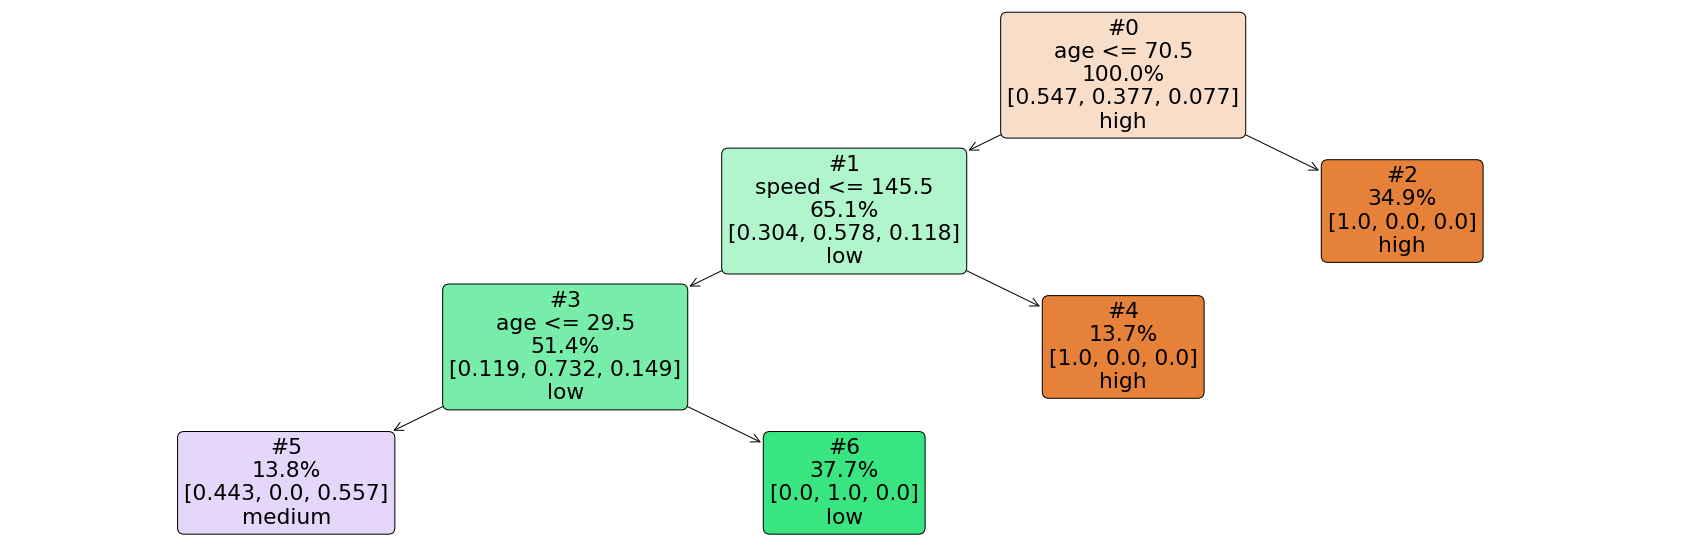

In [27]:
# https://scikit-learn.org/stable/modules/tree.html
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
# https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names=['speed', 'age']
class_names=['high', 'low', 'medium']

plt.figure(figsize=(30, 10))
plot_tree(surrogate_model, 
          feature_names=feature_names,
          class_names=class_names,
          impurity=False,
          label='none',
          rounded=True,
          node_ids=True,
          proportion=True,
          filled=True);

## Generating back code - choose code style as a bonus

In [28]:
# derived from https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

from sklearn.tree import _tree

def generate_code(model, feature_names, class_names, flat=False, batch=True):
    tree_ = model.tree_
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    value = model.tree_.value

    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth, conditions, outputs):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            condition = "{} <= {}".format(name, threshold)
            if not flat:
              print ("{}if {}:".format(indent, condition))
            recurse(tree_.children_left[node], depth + 1, conditions + [condition], outputs)
            condition = "{} > {}".format(name, threshold)
            if not flat:
              print ("{}else:  # if {}".format(indent, condition))
            recurse(tree_.children_right[node], depth + 1, conditions + [condition], outputs)
        else:
            prediction = class_names[value[node].argmax(axis=1)[0]]
            conjunction = ' and '.join(conditions)
            if flat and not batch:
              print ("  if {}:".format(conjunction))
            if not flat or not batch:
              print ("{}return '{}'".format(indent, prediction))
            else:
                if prediction in outputs: 
                  outputs[prediction] += [conjunction] 
                else:
                  outputs[prediction] = [conjunction]
        return outputs
              

    outputs = recurse(0, 1, [], {})
    if flat and batch:
      for prediction in outputs.keys():
          conjunctions = outputs[prediction]
          disjunction = ' or\n     '.join(conjunctions)
          print ("  if {}:".format(disjunction))
          print ("    return '{}':".format(prediction))
    
# generate_code(surrogate_model, feature_names, class_names)    

In [29]:
generate_code(surrogate_model, feature_names, class_names, flat=False)

def tree(speed, age):
  if age <= 70.5:
    if speed <= 145.5:
      if age <= 29.5:
        return 'medium'
      else:  # if age > 29.5
        return 'low'
    else:  # if speed > 145.5
      return 'high'
  else:  # if age > 70.5
    return 'high'


In [30]:
generate_code(surrogate_model, feature_names, class_names, flat=True, batch=False)

def tree(speed, age):
  if age <= 70.5 and speed <= 145.5 and age <= 29.5:
        return 'medium'
  if age <= 70.5 and speed <= 145.5 and age > 29.5:
        return 'low'
  if age <= 70.5 and speed > 145.5:
      return 'high'
  if age > 70.5:
    return 'high'


In [31]:
generate_code(surrogate_model, feature_names, class_names, flat=True)

def tree(speed, age):
  if age <= 70.5 and speed <= 145.5 and age <= 29.5:
    return 'medium':
  if age <= 70.5 and speed <= 145.5 and age > 29.5:
    return 'low':
  if age <= 70.5 and speed > 145.5 or
     age > 70.5:
    return 'high':
